In [1]:
import torch
from torch import nn

In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.has_mps

True

In [4]:
device = "mps" if torch.has_mps else "cpu"

In [5]:
from pathlib import Path

In [6]:
data_path  =Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"


Random image path: data/pizza_steak_sushi/train/steak/3245622.jpg
Image class: steak
Image height: 262
Image width: 512


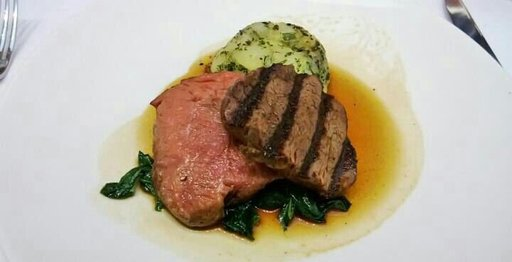

In [7]:
import random
from PIL import Image

random.seed(421)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
## Image Transformation 
data_transform = transforms.Compose([
    ## Resizing The Image ##
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
    transforms.ToTensor()

])

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


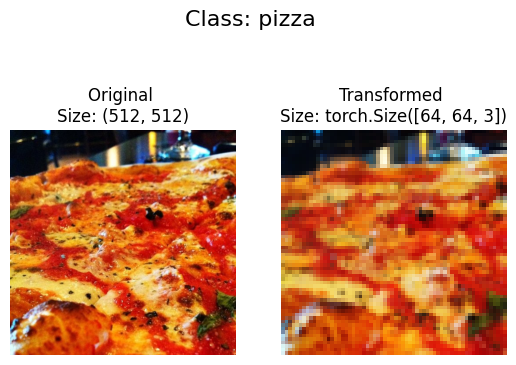

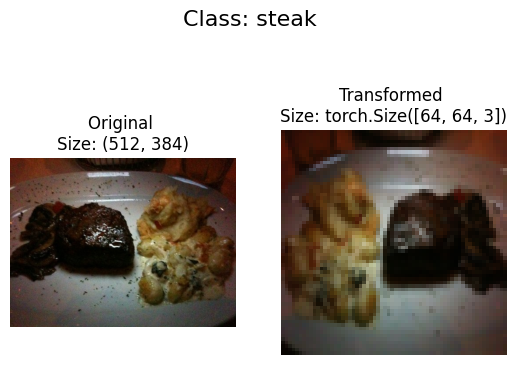

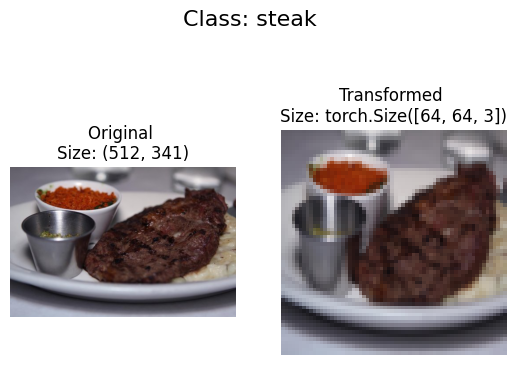

In [11]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [12]:
# Using Image Folder to create DataSets
from torchvision import datasets

In [13]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

In [14]:
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [15]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [16]:
class_dict = train_data.class_to_idx

In [17]:
class_name = train_data.classes

In [18]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
img, label = train_data[0][0], train_data[0][1]

In [20]:
img.shape

torch.Size([3, 64, 64])

In [21]:
img.shape

torch.Size([3, 64, 64])

In [22]:
img_permute = img.permute(1, 2, 0)

In [23]:
img_permute.shape

torch.Size([64, 64, 3])

Text(0.5, 1.0, 'pizza')

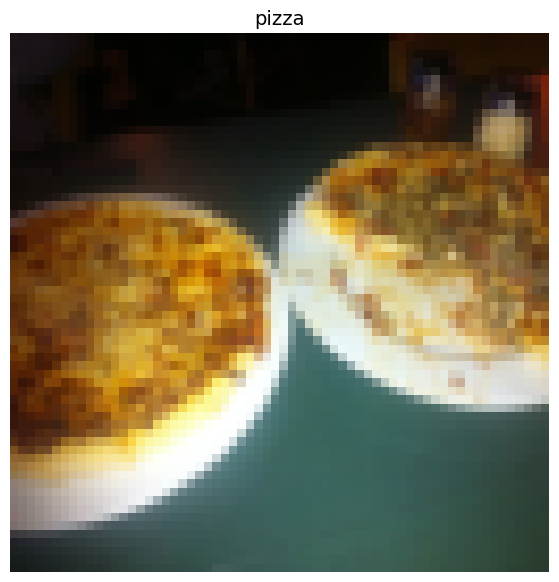

In [24]:
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_name[label], fontsize=14)

In [27]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x147d73610>,
 <torch.utils.data.dataloader.DataLoader at 0x147d5edc0>)

In [28]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Using Custom DataSet 

In [31]:
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List

import os
import pathlib

In [32]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['.DS_Store', 'pizza', 'steak', 'sushi']


In [37]:
class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir: str, transform=None) -> None:

        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        self.transform = transform

        self.classes = ['pizza', 'steak', 'sushi']
        self.class_to_idx = {'pizza': 0, 'steak': 1, 'sushi': 2}


    def load_image(self, index:int) -> Image.Image:
        """Open Image from path via index and returns it

        :param index: Index
        :type index: int

        :return: Image
        :rtype: Image.Image
        """

        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __len__(self) -> int:
        "Returns the total number of samples"
        return len(self.paths)
    

    ## Overriding this is required 
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        """Returns One Sample of data; (data  & Label)


        :param index: _description_
        :type index: int
        :return: _description_
        :rtype: Tuple[torch.Tensor, int]
        """

        img = self.load_image(index=index)

        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        
        else:
            return img, class_idx        

In [38]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [39]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1680aa7c0>,
 <__main__.ImageFolderCustom at 0x147dcc9d0>)

In [40]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [41]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [42]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [43]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

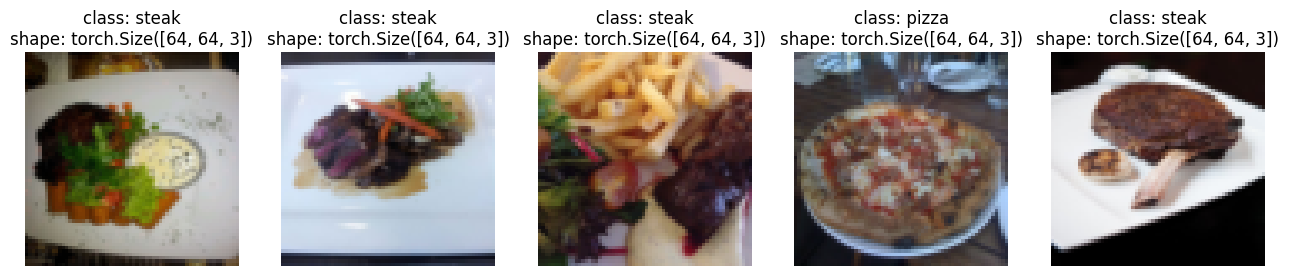

In [44]:
display_random_images(train_data_custom, 
                      n=5, 
                      classes=train_data_custom.classes,
                      seed=None)

## DataLoader

In [45]:
train_dataloader_cs = DataLoader(dataset=train_data_custom,
                                 batch_size=10,
                                 num_workers=0,
                                 shuffle=True)

test_dataloader_cs = DataLoader(dataset=test_data_custom,
                                batch_size=10,
                                num_workers=0,
                                shuffle=False)

In [46]:

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_cs))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([10, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([10])


In [47]:
## Image Transformation 
data_transform = transforms.Compose([
    ## Resizing The Image ##
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
    transforms.ToTensor()

])

In [48]:
transform_new = torch.nn.Sequential(
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
)

In [49]:
train_data_no_ts = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=None)

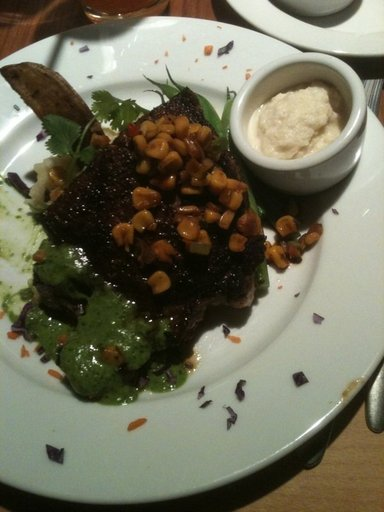

In [50]:
train_data_no_ts[0][0]

In [51]:
from torchvision import transforms

In [52]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31)

])

In [53]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

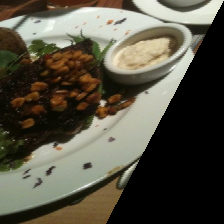

In [54]:
ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)[0][0]

## TinyVGG without Data Augmentation

In [75]:
simple_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

In [76]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)


In [77]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [78]:
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

In [79]:
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [93]:
class TinyVGG(nn.Module):
    """TinyVGG Architecture


    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super(TinyVGG, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)         
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16,
                      out_features=output_shape)
        )

    
    def forward(self, x:torch.Tensor):

        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
    

        return x

In [89]:
torch.manual_seed(45)

In [94]:
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=3)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=3, bias=True)
  )
)

In [91]:
image_batch , label_batch = next(iter(train_dataloader_simple))

In [95]:
model_0(image_batch)

tensor([[ 0.0249, -0.0191,  0.0048],
        [ 0.0222, -0.0229,  0.0093],
        [ 0.0261, -0.0191,  0.0039],
        [ 0.0270, -0.0222,  0.0045],
        [ 0.0218, -0.0202,  0.0083],
        [ 0.0270, -0.0213,  0.0013],
        [ 0.0299, -0.0206,  0.0017],
        [ 0.0257, -0.0207,  0.0055],
        [ 0.0273, -0.0222,  0.0034],
        [ 0.0253, -0.0209,  0.0076],
        [ 0.0240, -0.0237,  0.0072],
        [ 0.0281, -0.0209,  0.0036],
        [ 0.0266, -0.0173,  0.0035],
        [ 0.0258, -0.0175,  0.0057],
        [ 0.0264, -0.0235,  0.0060],
        [ 0.0269, -0.0174,  0.0042],
        [ 0.0264, -0.0231,  0.0050],
        [ 0.0260, -0.0176,  0.0054],
        [ 0.0279, -0.0200,  0.0059],
        [ 0.0272, -0.0170,  0.0046],
        [ 0.0241, -0.0217,  0.0067],
        [ 0.0282, -0.0198,  0.0071],
        [ 0.0284, -0.0195,  0.0019],
        [ 0.0279, -0.0196,  0.0026],
        [ 0.0275, -0.0144,  0.0092],
        [ 0.0276, -0.0244,  0.0015],
        [ 0.0251, -0.0199,  0.0074],
 

In [96]:
model_0(train_data_simple[0][0].unsqueeze(dim=0))

tensor([[ 0.0234, -0.0151,  0.0038]], grad_fn=<AddmmBackward0>)

In [97]:
from torchinfo import summary

In [98]:
summary(model_0, input_size=[64,3, 28, 28])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [64, 3]                   --
├─Sequential: 1-1                        [64, 10, 12, 12]          --
│    └─Conv2d: 2-1                       [64, 10, 26, 26]          280
│    └─ReLU: 2-2                         [64, 10, 26, 26]          --
│    └─Conv2d: 2-3                       [64, 10, 24, 24]          910
│    └─ReLU: 2-4                         [64, 10, 24, 24]          --
│    └─MaxPool2d: 2-5                    [64, 10, 12, 12]          --
├─Sequential: 1-2                        [64, 10, 4, 4]            --
│    └─Conv2d: 2-6                       [64, 10, 10, 10]          910
│    └─ReLU: 2-7                         [64, 10, 10, 10]          --
│    └─Conv2d: 2-8                       [64, 10, 8, 8]            910
│    └─ReLU: 2-9                         [64, 10, 8, 8]            --
│    └─MaxPool2d: 2-10                   [64, 10, 4, 4]            --
├─Sequentia

In [99]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

In [100]:
loss_fn = nn.CrossEntropyLoss()

In [101]:
from tqdm.auto import tqdm

In [72]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0

    model.to(device)

    for batch, (X,y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_pred = model(X)

        # 2. Calculate Loss #
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))
        
        # 3. Optimizer Zero Grad

        optimizer.zero_grad()

        # 4. Loss Backward

        loss.backward()

        # 5. Optimizer Step

        optimizer.step()


    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [102]:
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [103]:
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model_0, train_dataloader_simple,
               loss_fn, optimizer, accuracy_fn, "mps")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------


 20%|██        | 1/5 [00:42<02:50, 42.67s/it]

Train loss: 1.09696 | Train accuracy: 42.58%
Epoch: 1
---------


 40%|████      | 2/5 [01:24<02:07, 42.45s/it]

Train loss: 1.10573 | Train accuracy: 30.47%
Epoch: 2
---------


 60%|██████    | 3/5 [02:07<01:25, 42.50s/it]

Train loss: 1.09482 | Train accuracy: 42.58%
Epoch: 3
---------


 80%|████████  | 4/5 [02:49<00:42, 42.46s/it]

Train loss: 1.10301 | Train accuracy: 30.47%
Epoch: 4
---------


100%|██████████| 5/5 [03:32<00:00, 42.48s/it]

Train loss: 1.11231 | Train accuracy: 26.17%


In [104]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    ## Put Modelling In Eval Mode

    model.eval()

    ## Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        # Loop Through DataLoader Batches
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            # 1. Forward Pass
            test_pred_logits = model(X)

            # 2. Calc and accyumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and Accumulate Accuracy 
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    
    # Adjust metrics to gret avg loss & acc per bath

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


In [107]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    ## 2. Create Empty Results Dictionary

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }
    
    ## 3. Loop through training and testing steps for a number of epochs

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn)
        
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        return results



In [108]:
model_0_results = train(model_0, train_data_simple, train_data_simple, optimizer, loss_fn, 5)

  0%|          | 0/5 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'to'